In [1]:
from msc_project.experiments.fault_tolerant_boolean_circuits.fault_tolerant_logic_gates import robust_xor, maj_n
from msc_project.utils.experiment_utils import ModelSpecs, ModelType
from circuits.neurons.operations import xor, bitwise
from circuits.neurons.core import Bit, gate, Neuron, step, BitFn
from circuits.tensors.mlp import Bits
from circuits.examples.keccak import Keccak
import matplotlib.pyplot as plt
from msc_project.utils.circuit_visualiser import CircuitVisualiser
from circuits.sparse.compile import compiled_from_io, compiled
from msc_project.experiments.fault_tolerant_boolean_circuits.perturbable_stepmlp import PerturbableStepMLP
import numpy as np
import torch
import copy
from msc_project.experiments.fault_tolerant_boolean_circuits.monitor import Monitor
import pandas as pd
import seaborn as sns
import math
from collections.abc import Callable
import matplotlib as mpl
from functools import partial
from msc_project.experiments.fault_tolerant_boolean_circuits.robust_keccak import RobustKeccak

In [36]:
pd.set_option('display.max_colwidth', None)

In [2]:
base = "/scratch/local/ssd/bella/msc-project/results/experiment_noise_tolerance/error_trace"

In [3]:
def noisy_xor(x : list[Bit], std: float) -> Bit:
    counter_weights = 1 + np.random.normal(loc=0.0, scale=std, size=(len(x), len(x)))
    bias_noise = np.random.normal(loc=0.0, scale=std, size=(len(x)))
    counters = [gate(x, weights, i + 1 + n) for i, weights, n in zip(range(len(x)), counter_weights, bias_noise)]
    final_noise = np.random.normal(loc=0.0, scale=std, size=(len(x)))
    final_bias_noise = np.random.normal(loc=0.0, scale=std, size=1)
    return gate(counters, [((-1) ** i) + noise for i, noise in zip(range(len(x)), final_noise)], 1 + final_bias_noise[0])

In [4]:
def gate(incoming: list[Bit], weights: list[float], threshold: float) -> Bit:
    """Create a linear threshold gate as a boolean neuron with a step function"""
    return Neuron(tuple(incoming), tuple(weights), -threshold, step).outgoing

def not_(x: Bit, std: float) -> Bit:
    weight : float = torch.randn(1).item() * std
    bias : float = torch.randn(1).item() * std
    return gate([x], [-1 + weight], bias)


def or_(x: list[Bit], std: float) -> Bit:
    weights = 1 + torch.randn(len(x)) * std
    bias = 1 + torch.randn(1).item() * std
    return gate(x, weights.tolist(), bias)


def and_(x: list[Bit], std: float) -> Bit:
    weights = 1 + torch.randn(len(x)) * std
    bias = len(x) + torch.randn(1).item() * std
    return gate(x, weights.tolist(), bias)

In [5]:
def noisy_robust_xor(x: list[Bit], std: float) -> Bit:
    
    def robust_xor2(a: Bit, b: Bit) -> Bit:
        a_or_b = or_([a, b], std)
        a_and_b = and_([a, b], std)
        not_a_and_b = not_(a_and_b, std)
        return and_([a_or_b, not_a_and_b], std)

    result = x[0]
    for bit in x[1:]:
        result = robust_xor2(result, bit)
    return result

In [6]:
def noisy_maj_n(x: list[Bit], std: float) -> Bit:
    weights = 1 + torch.randn(len(x)) * std
    bias = (math.ceil(len(x) / 2)) + torch.randn(1).item() * std
    return gate(x, weights.tolist(), bias)

In [7]:
def noisy_amp(x: Bit, std: float, amp_rate: int) -> list[Bit]:
    weights = (1 + torch.randn(amp_rate) * std).tolist()
    biases = (1 + torch.randn(amp_rate) * std).tolist()
    copies = [gate([x], [weights[i]], biases[i]) for i in range(amp_rate)]

    return copies

def amp(x: Bit, amp_rate: int) -> list[Bit]:
    copies = [gate([x], [1], 1) for _ in range(amp_rate)]
    return copies

In [8]:
def noisy_amps(x: list[Bit], std, amp_rate: int) -> list[list[Bit]]:
    copies = [noisy_amp(x_i, std, amp_rate) for x_i in x]
    copies = np.array(copies).T.tolist()
    return copies

def amps(x: list[Bit], amp_rate: int) -> list[list[Bit]]:
    copies = [amp(x_i, amp_rate) for x_i in x]
    copies = np.array(copies).T.tolist()
    return copies

In [9]:
copies = noisy_amps(Bits.from_str("1001").bitlist, 0.0, 3)

In [10]:
def noisy_maj_xor(x: list[Bit], std: float, redundancy: int, xor_fn: Callable[[list[Bit], float], Bit]) -> Bit:
    ambivalents = [xor_fn(x, std) for _ in range(redundancy)]
    return noisy_maj_n(ambivalents, std)

def get_noisy_maj_xor(redundancy: int, xor_fn) -> Callable[[list[Bit], float], Bit]:

    def xor(x: list[Bit], std: float) -> Bit:
        return noisy_maj_xor(x, std, redundancy, xor_fn)
    
    return xor

def get_maj_xor_bitfn(redundancy: int, xor_fn) -> BitFn:

    def xor(x: list[Bit]) -> list[Bit]:
        ambivalents = [xor_fn(x) for _ in range(redundancy)]
        return [maj_n(ambivalents)]
    
    return xor

In [11]:
def noisy_amp_maj_xor(x: list[Bit], std: float, redundancy: int, xor_fn: Callable[[list[Bit], float], Bit]) -> Bit:
    x_amp = noisy_amps(x, std, redundancy)
    ambivalents = [xor_fn(x_i, std) for x_i in x_amp]
    return noisy_maj_n(ambivalents, std)

def get_noisy_amp_maj_xor(redundancy: int, xor_fn) -> Callable[[list[Bit], float], Bit]:

    def xor(x: list[Bit], std: float) -> Bit:
        return noisy_amp_maj_xor(x, std, redundancy, xor_fn)
    
    return xor

def get_amp_maj_xor_bitfn(redundancy: int, xor_fn) -> BitFn:

    def xor(x: list[Bit]) -> list[Bit]:
        copies = amps(x, redundancy)
        ambivalents = [xor_fn(x_i) for x_i in copies]
        return [maj_n(ambivalents)]
    
    return xor

In [12]:
def get_noisy_xor_fn(std: float) -> BitFn:

    def xor(x:list[Bit]) -> list[Bit]:
        return [noisy_xor(x, std)]
    
    return xor

def get_noisy_robust_xor_fn(std: float) -> BitFn:

    def xor(x:list[Bit]) -> list[Bit]:
        return [noisy_robust_xor(x, std)]
    
    return xor

In [13]:
noise_stds = np.linspace(0.0010, 1.0, 100)

In [14]:
def get_gate_success_rates(xor_fn, input, expected_output, stds, num_samples) -> list[float]:

    np.random.seed(95)
    success_rates = []

    for std in stds:
        num_sucesses = 0
        for _ in range(num_samples):
            actual_output = xor_fn(input, std)

            num_sucesses += (actual_output.activation == expected_output)

        success_rates.append(num_sucesses / num_samples)

    return success_rates

In [15]:
def get_graph_success_rates(get_xor_fn, input, expected_output, stds, num_samples) -> list[float]:

    np.random.seed(95)
    success_rates = []

    for std in stds:
        num_sucesses = 0
        for _ in range(num_samples):
            xor_fn = get_xor_fn(std)
            graph = compiled(xor_fn, len(input))
            actual_output = graph.run(input)

            num_sucesses += (actual_output[0].activation == expected_output)

        success_rates.append(num_sucesses / num_samples)

    return success_rates

In [16]:
def get_success_rates(xor_fn, input, stds, num_samples):

    np.random.seed(95)
    success_rates = []
    models = []
    activations = []

    graph = compiled(xor_fn, len(input))
    mlp = PerturbableStepMLP.from_graph(graph)
    monitor = Monitor()
    monitor.register_hooks(mlp)
    expected_output = copy.deepcopy(mlp.infer_bits(input))

    activations.append(monitor.to_dataframe(std = 0.0))
    monitor.clear_data()
    
    for std in stds:
        num_sucesses = 0
        curr_models = []
        for _ in range(num_samples):
            mlp.perturb(std)
            curr_models.append(copy.deepcopy(mlp))
            actual_output = mlp.infer_bits(input)

            num_sucesses += (actual_output.bitstr == expected_output.bitstr)
            mlp.reset()
        models.append(curr_models)
        activations.append(monitor.to_dataframe(std=std))
        monitor.clear_data()
        success_rates.append(num_sucesses / num_samples)

    return success_rates, models, activations


In [55]:
def xor_fn(x: list[Bit]) -> list[Bit]:
    return [xor(x)]

def robust_xor_fn(x: list[Bit]) -> list[Bit]:
    return [robust_xor(x)]

In [18]:
success_rates_xor_gate = get_gate_success_rates(noisy_xor, Bits.from_str("1001").bitlist, 0, noise_stds, 100)

In [19]:
input_bits = Bits.from_str("1001")
input = input_bits.bitlist
output = Bits.from_str("0")

In [20]:
success_rates_robust_xor_gate = get_gate_success_rates(noisy_robust_xor, Bits.from_str("1001").bitlist, 0, noise_stds, 100)

In [21]:
success_rates_maj_xor_gate = {}
success_rates_maj_robust_xor_gate = {}
success_rates_maj_xor_gate[1] = get_gate_success_rates(get_noisy_maj_xor(1, noisy_xor), input, 0, noise_stds, 100)
success_rates_maj_robust_xor_gate[1] = get_gate_success_rates(get_noisy_maj_xor(1, noisy_robust_xor), input, 0, noise_stds, 100)
success_rates_maj_xor_gate[3] = get_gate_success_rates(get_noisy_maj_xor(3, noisy_xor), input, 0, noise_stds, 100)
success_rates_maj_robust_xor_gate[3] = get_gate_success_rates(get_noisy_maj_xor(3, noisy_robust_xor), input, 0, noise_stds, 100)
success_rates_maj_xor_gate[5] = get_gate_success_rates(get_noisy_maj_xor(5, noisy_xor), input, 0, noise_stds, 100)
success_rates_maj_robust_xor_gate[5] = get_gate_success_rates(get_noisy_maj_xor(5, noisy_robust_xor), input, 0, noise_stds, 100)
success_rates_maj_xor_gate[7] = get_gate_success_rates(get_noisy_maj_xor(7, noisy_xor), input, 0, noise_stds, 100)
success_rates_maj_robust_xor_gate[7] = get_gate_success_rates(get_noisy_maj_xor(7, noisy_robust_xor), input, 0, noise_stds, 100)

success_rates_amp_maj_xor_gate = {}
success_rates_amp_maj_robust_xor_gate = {}
success_rates_amp_maj_xor_gate[1] = get_gate_success_rates(get_noisy_amp_maj_xor(1, noisy_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_robust_xor_gate[1] = get_gate_success_rates(get_noisy_amp_maj_xor(1, noisy_robust_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_xor_gate[3] = get_gate_success_rates(get_noisy_amp_maj_xor(3, noisy_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_robust_xor_gate[3] = get_gate_success_rates(get_noisy_amp_maj_xor(3, noisy_robust_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_xor_gate[5] = get_gate_success_rates(get_noisy_amp_maj_xor(5, noisy_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_robust_xor_gate[5] = get_gate_success_rates(get_noisy_amp_maj_xor(5, noisy_robust_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_xor_gate[7] = get_gate_success_rates(get_noisy_amp_maj_xor(7, noisy_xor), input, 0, noise_stds, 100)
success_rates_amp_maj_robust_xor_gate[7] = get_gate_success_rates(get_noisy_amp_maj_xor(7, noisy_robust_xor), input, 0, noise_stds, 100)

In [22]:
noise_stds = np.linspace(0.0010, 1.0, 20)
xor_fns = [xor, robust_xor]
xor_fns_names = ["Baseline XOR", "Robust XOR"]
maj_fns = [get_maj_xor_bitfn]
maj_fns_names = ["Majority"]
voters = [1, 3, 5, 7]
success_rates_mlp = {}
models_mlp = {}
activations_mlp = {}

for xor_fn, xor_fn_name in zip(xor_fns, xor_fns_names):
    for maj_fn, maj_fn_name in zip(maj_fns, maj_fns_names):
        key = f"{xor_fn_name}"
        tmp_success_rates = {}
        tmp_models = {}
        tmp_activations = {}
        for num_voters in voters:
            partial_xor_fn = maj_fn(num_voters, xor_fn)
            tmp_success_rates[num_voters], tmp_models[num_voters], acts = get_success_rates(partial_xor_fn, input_bits, noise_stds, 100)
            tmp_activations[num_voters] = pd.concat(acts)

        success_rates_mlp[key] = tmp_success_rates
        models_mlp[key] = tmp_models
        activations_mlp[key] = tmp_activations


In [23]:
success_rates_mlp_df = pd.DataFrame(success_rates_mlp)
activations_mlp_df = pd.DataFrame(activations_mlp)

In [24]:
success_rates_mlp_df

,Baseline XOR,Robust XOR
1,"[1.0, 1.0, 1.0, 0.93, 0.84, 0.67, 0.63, 0.56, ...","[1.0, 1.0, 0.9, 0.41, 0.36, 0.42, 0.62, 0.59, ..."
3,"[1.0, 1.0, 1.0, 0.83, 0.71, 0.62, 0.41, 0.36, ...","[1.0, 0.99, 0.59, 0.37, 0.4, 0.39, 0.41, 0.39,..."
5,"[1.0, 1.0, 0.99, 0.76, 0.54, 0.47, 0.38, 0.38,...","[1.0, 0.97, 0.44, 0.34, 0.3, 0.27, 0.32, 0.37,..."
7,"[1.0, 1.0, 0.94, 0.8, 0.52, 0.38, 0.36, 0.3, 0...","[1.0, 0.9, 0.42, 0.4, 0.34, 0.34, 0.33, 0.36, ..."


In [25]:
success_rates_xor_graph = get_graph_success_rates(get_noisy_xor_fn, Bits.from_str("1001").bitlist, 0, noise_stds, 100)
success_rates_robust_xor_graph = get_graph_success_rates(get_noisy_robust_xor_fn, Bits.from_str("1001").bitlist, 0, noise_stds, 100)

In [26]:
cmap = mpl.colormaps['plasma']
colours = cmap(np.linspace(0,0.9,4))
linestyles = ["-", "--", "-.", ":"]

In [27]:
success_rates_gates = {
    "Baseline XOR": success_rates_maj_xor_gate,
    "Robust XOR": success_rates_maj_robust_xor_gate,
    "Baseline XOR + AMP": success_rates_amp_maj_xor_gate,
    "Robust XOR + AMP": success_rates_amp_maj_robust_xor_gate
}

success_rates_df = pd.DataFrame(success_rates_gates)

In [28]:
success_rates_df.columns[0]

'Baseline XOR'

In [29]:
def plot_success_rates(success_rates_df: pd.DataFrame, noise_stds: list[float], cmap_name : str = "plasma"):
        
    voters = success_rates_df.index.tolist()
    models = success_rates_df.columns
    fig, axes = plt.subplots(len(voters), 1, figsize=(15, 3*len(voters)))

    cmap = mpl.colormaps[cmap_name]
    colours = cmap(np.linspace(0,0.9,len(voters)))

    for ax, num_voters in zip(axes, voters):
        data = success_rates_df.loc[num_voters]
        for i, model in enumerate(models):
            model_data = data[model]
            ax.plot(noise_stds, model_data, color = colours[i], label=model)
        
        ax.set_ylabel("Success Rate (%)", fontsize='large')
        ax.set_xlabel("Standard Deviation", fontsize='large')
        ax.annotate(f"Number of voters: {num_voters}", xy=(-0.3, 0.5), xycoords=ax.transAxes, fontsize='x-large')
        ax.tick_params(labelsize='medium')
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncols=len(models), bbox_to_anchor=(0.6, 1.04), fontsize='large')
    fig.tight_layout()
    return fig
    

ValueError: x and y must have same first dimension, but have shapes (20,) and (100,)

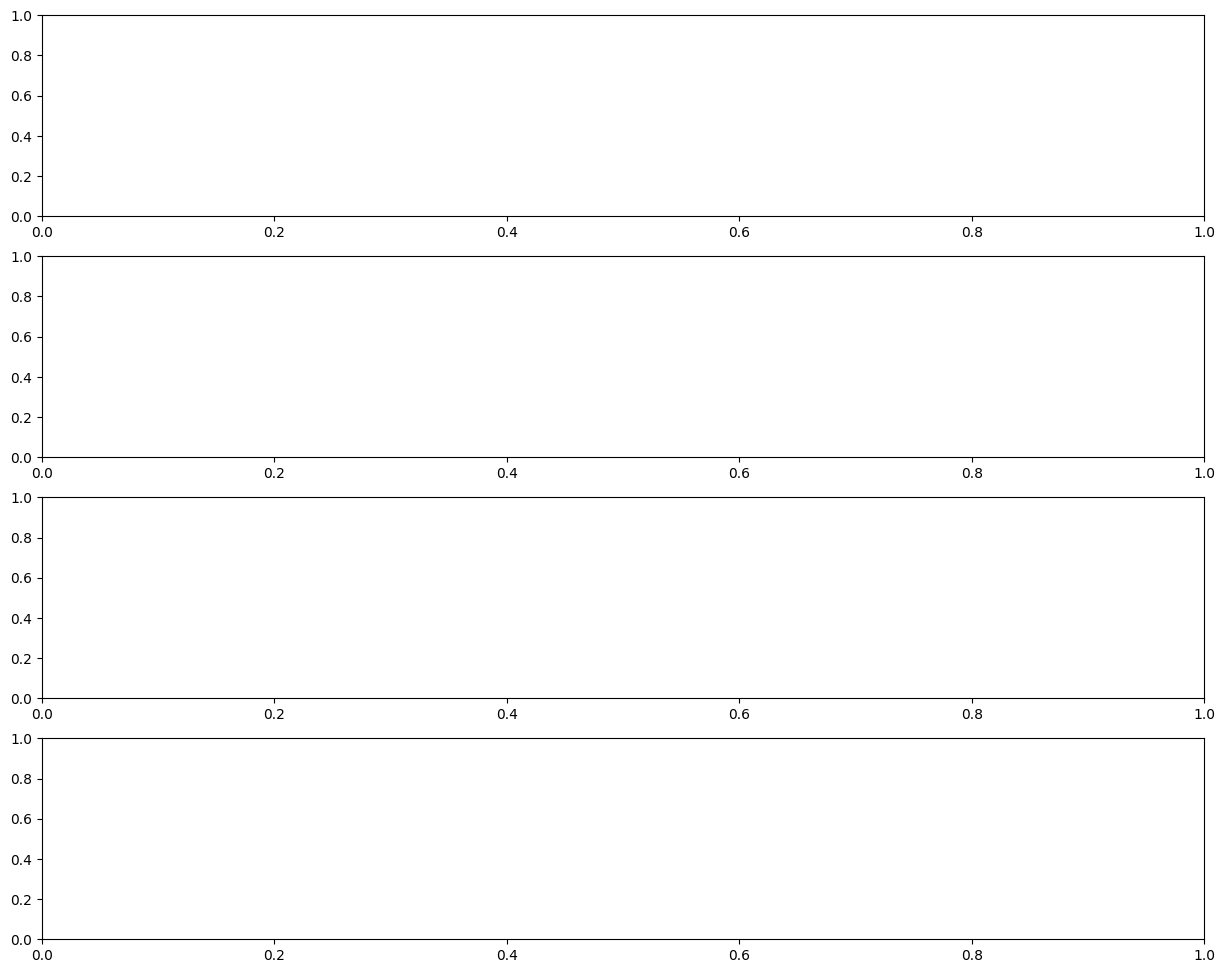

In [30]:
f = plot_success_rates(success_rates_df, noise_stds.tolist())

In [ ]:
success_rates_mlp_df_reduces = success_rates_mlp_df.drop(columns=["Baseline XOR Majority + AMP", "Robust XOR Majority + AMP"])

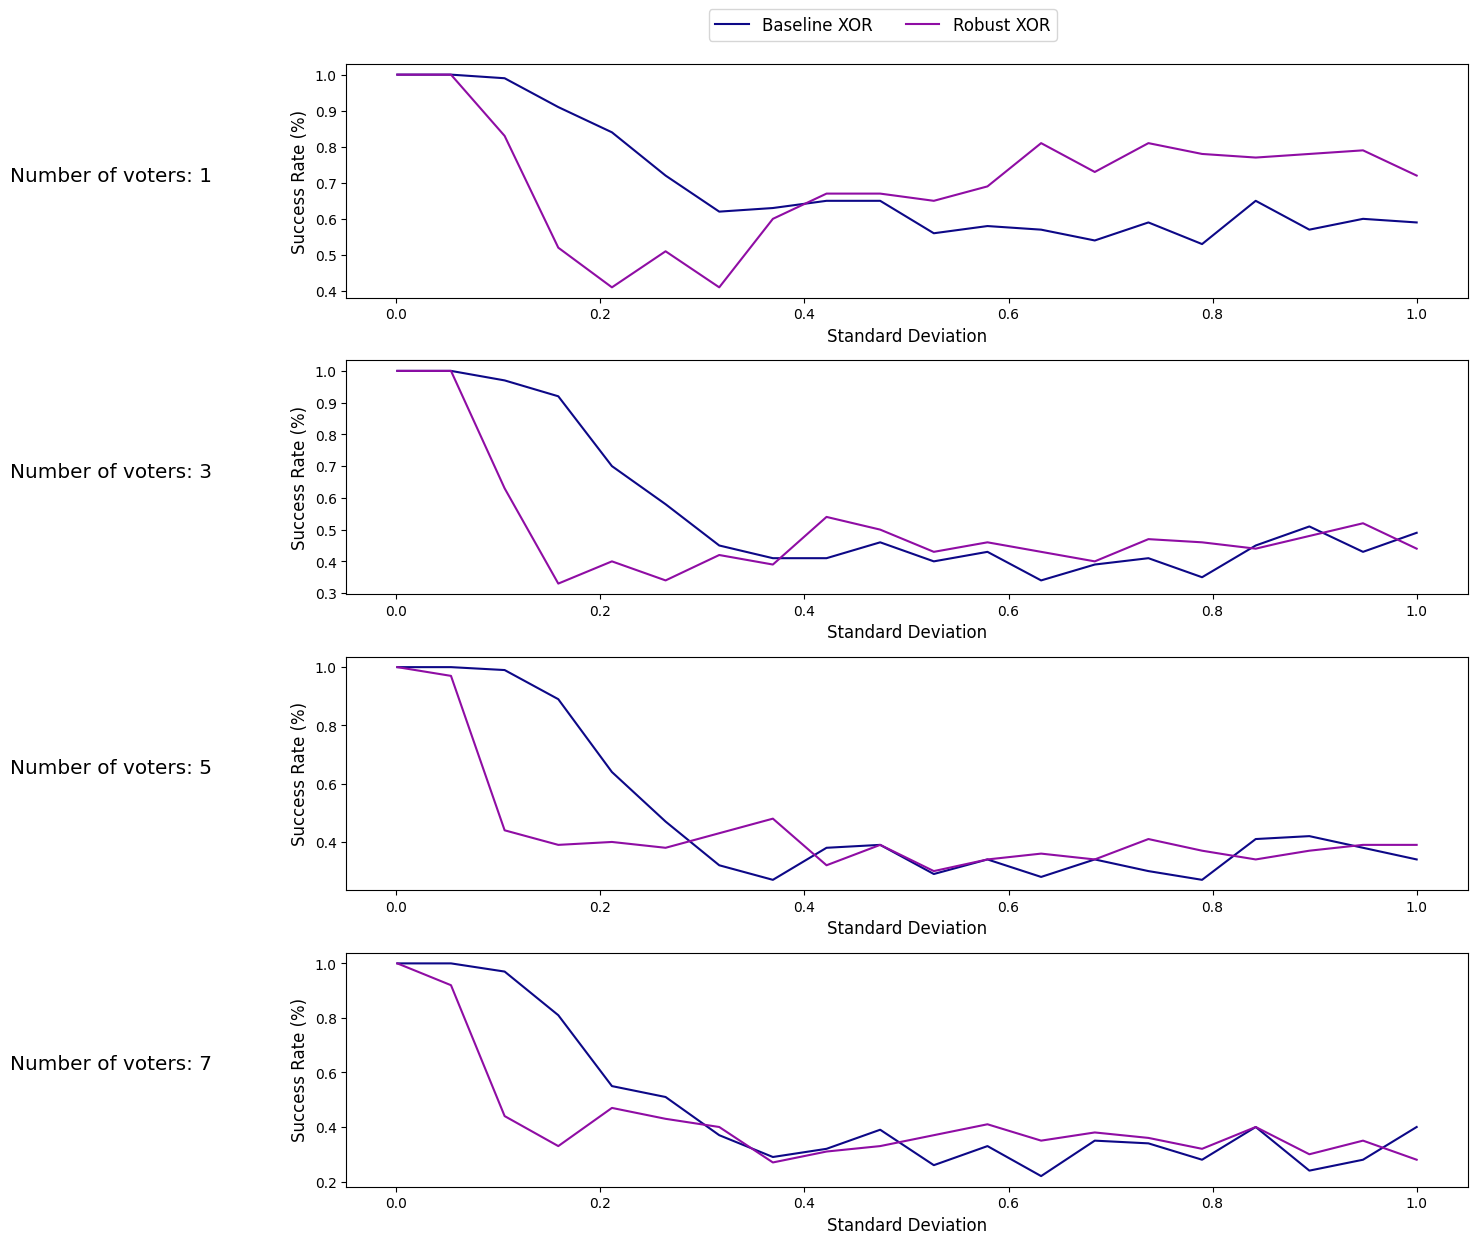

In [ ]:
f = plot_success_rates(success_rates_mlp_df, noise_stds.tolist())
f.savefig(f"{base}/mlp_success_rate_per_num_voters_20_stds.pdf", bbox_inches="tight")

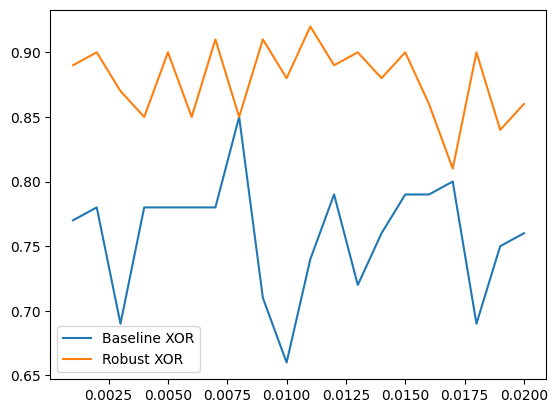

In [ ]:
plt.plot(noise_stds, success_rates_xor_graph, label="Baseline XOR")
plt.plot(noise_stds, success_rates_robust_xor_graph, label="Robust XOR")
plt.legend()

In [ ]:
success_rate_xor_mlp, xor_mlps, xor_activations = get_success_rates(xor_fn, Bits.from_str("101"), noise_stds, 100)
success_rate_robust_xor_mlp, robust_xor_mlps, robust_xor_activations = get_success_rates(robust_xor_fn, Bits.from_str("101"), noise_stds, 100)

In [ ]:
xor_df = pd.concat(xor_activations)
robust_xor_df = pd.concat(robust_xor_activations)

In [ ]:
def compute_activation_diffs(df: pd.DataFrame) -> pd.DataFrame:
    
    def calc_diff_from_baseline(group):
        """For each group (model,layer_idx), compute differences from baseline."""
        
        # Find baseline row
        baseline = group[group['std'] == 0.0]
        
        if len(baseline) == 0:
            return pd.DataFrame()  # No baseline for this group
        
        baseline = baseline.iloc[0]
        baseline_pre = baseline['pre_activations']
        baseline_post = baseline['post_activations']
        
        # Compute differences for all noisy rows
        noisy = group[group['std'] > 0.0].copy()
        
        noisy['pre_diff'] = noisy['pre_activations'].apply(lambda x: np.abs(x - baseline_pre))
        noisy['post_diff'] = noisy['post_activations'].apply(lambda x: np.abs(x - baseline_post))
        
        # Add summary statistics
        noisy['pre_mae'] = noisy['pre_diff'].apply(np.mean)
        noisy['post_ber'] = noisy['post_diff'].apply(np.mean)
        
        return noisy
    
    result = df.groupby(['layer_idx'], group_keys=False).apply(calc_diff_from_baseline)
    
    return result.reset_index(drop=True)

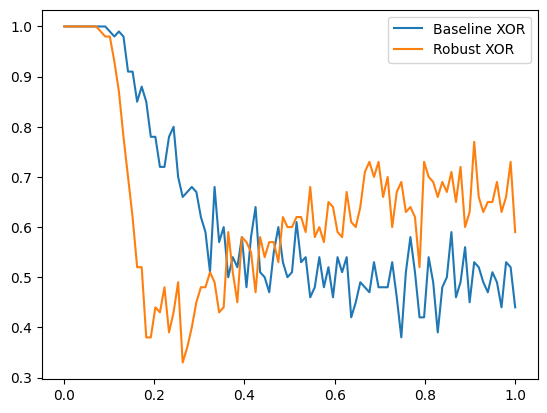

In [ ]:
plt.plot(noise_stds, success_rate_xor_mlp, label="Baseline XOR")
plt.plot(noise_stds, success_rate_robust_xor_mlp, label="Robust XOR")
plt.legend()

In [ ]:
activations_mlp_df["Baseline XOR"].index

Index([1, 3, 5, 7], dtype='int64')

In [ ]:
activation_errors = {}
mean_activation_errors = {}
for key, sub_dict in activations_mlp.items():
    tmp = {}
    tmp_mean = {}
    for sub_key, df in sub_dict.items():
        tmp[sub_key] = compute_activation_diffs(df)
        tmp_mean[sub_key] = tmp[sub_key].groupby(["layer_idx", "std"])[["pre_mae", "post_ber"]].mean()
    activation_errors[key] = tmp
    mean_activation_errors[key] = tmp_mean

/tmp/ipykernel_200476/2446897302.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['layer_idx'], group_keys=False).apply(calc_diff_from_baseline)
/tmp/ipykernel_200476/2446897302.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['layer_idx'], group_keys=False).apply(calc_diff_from_baseline)
/tmp/ipykernel_200476/2446897302.py:28: FutureWarning: DataFrameGroupBy.apply op

In [ ]:
xor_errors = compute_activation_diffs(xor_df)
robust_xor_errors = compute_activation_diffs(robust_xor_df)

/tmp/ipykernel_32323/2446897302.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['layer_idx'], group_keys=False).apply(calc_diff_from_baseline)
/tmp/ipykernel_32323/2446897302.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['layer_idx'], group_keys=False).apply(calc_diff_from_baseline)


In [ ]:
xor_error_means = xor_errors.groupby(["layer_idx", "std"])[["pre_mae", "post_ber"]].mean()
robust_xor_error_means = robust_xor_errors.groupby(["layer_idx", "std"])[["pre_mae", "post_ber"]].mean()

In [ ]:
robust_xor_error_means.to_csv()

'layer_idx,std,pre_mae,post_ber\n0,0.001,0.0013489781178073518,0.0\n0,0.011090909090909092,0.015522957134437671,0.0\n0,0.021181818181818184,0.0309122492367907,0.0\n0,0.03127272727272727,0.04254288315478821,0.0\n0,0.041363636363636366,0.05866356919361776,0.0\n0,0.05145454545454546,0.06743226636125932,0.0\n0,0.06154545454545455,0.09005657619253128,0.0\n0,0.07163636363636364,0.09833121703395882,0.0\n0,0.08172727272727273,0.1137096516262873,0.0\n0,0.09181818181818183,0.1190726830669794,0.0\n0,0.10190909090909092,0.14354243505354422,0.0\n0,0.112,0.15439831180861938,0.005\n0,0.1220909090909091,0.17052503820493783,0.0175\n0,0.13218181818181818,0.17317143653689906,0.0125\n0,0.14227272727272727,0.19241799778649277,0.025\n0,0.15236363636363637,0.2113659402865666,0.03\n0,0.16245454545454546,0.233048837516451,0.0375\n0,0.17254545454545456,0.2377556691231435,0.0575\n0,0.18263636363636365,0.2700919471441211,0.08\n0,0.19272727272727275,0.26466803982296616,0.065\n0,0.20281818181818184,0.27388856535292

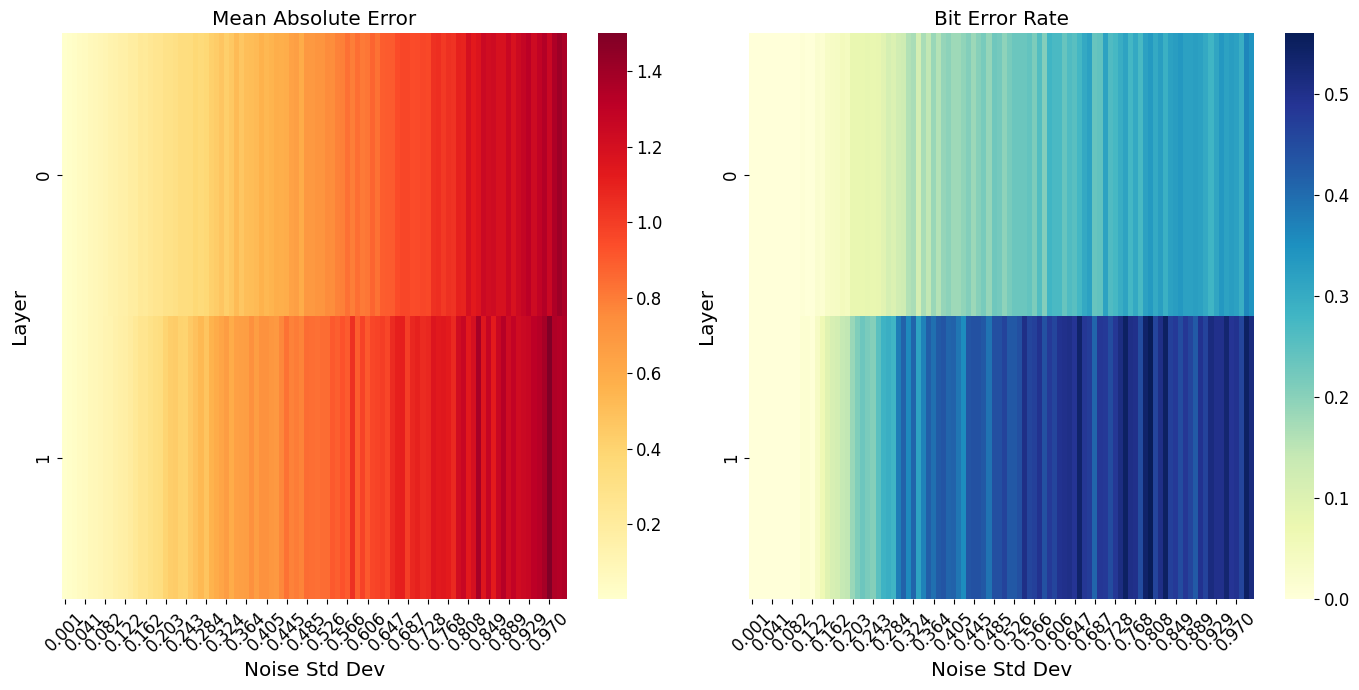

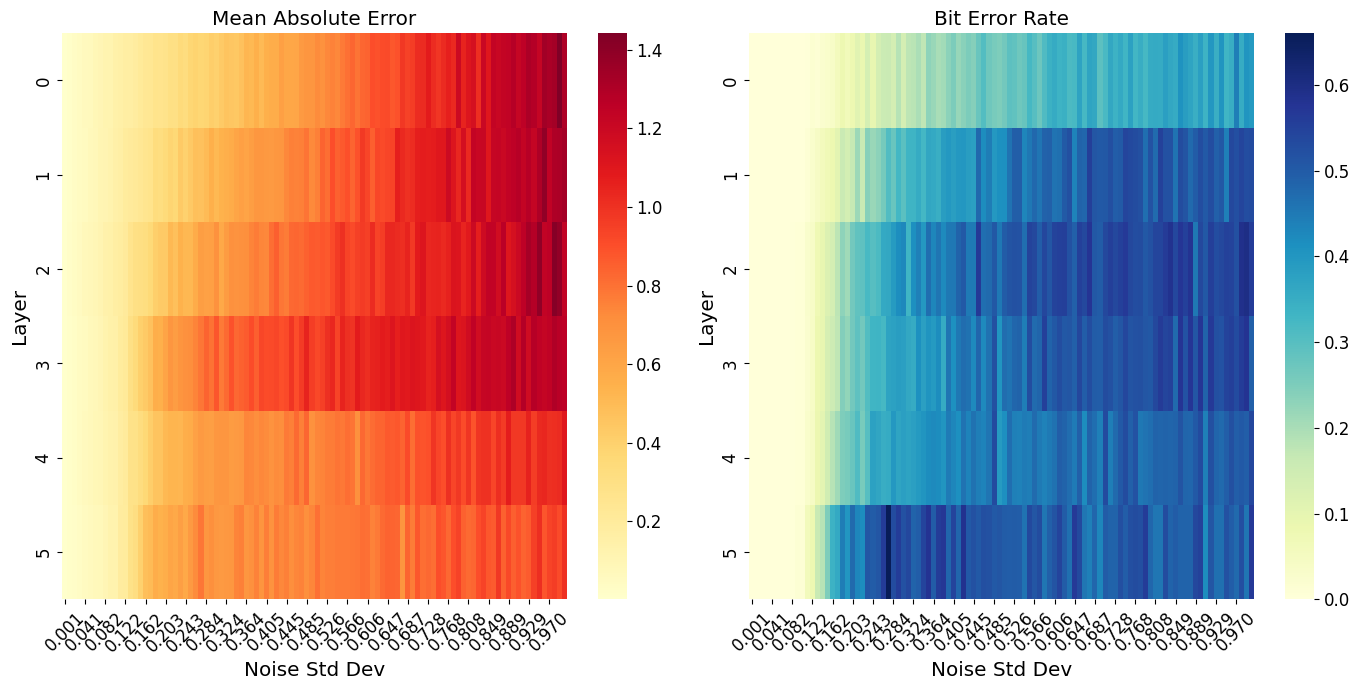

In [ ]:
for model_data in [xor_error_means, robust_xor_error_means]:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))


    mae_pivot = model_data['pre_mae'].unstack('std')
    ber_pivot = model_data['post_ber'].unstack('std')
    mae_pivot.columns = [f'{col:.3f}' for col in mae_pivot.columns]
    ber_pivot.columns = [f'{col:.3f}' for col in ber_pivot.columns]
    
    # MAE heatmap
    sns.heatmap(mae_pivot, ax=ax1, cmap='YlOrRd')
    cbar1 = ax1.collections[0].colorbar
    cbar1.ax.tick_params(labelsize='large')
    ax1.set_title(f'Mean Absolute Error', fontdict={'fontsize': 'x-large'})
    ax1.set_xlabel('Noise Std Dev', fontdict={'fontsize': 'x-large'})
    ax1.set_ylabel('Layer', fontdict={'fontsize': 'x-large'})
    ax1.tick_params(axis='x', labelrotation=45)
    
    ax1.tick_params(axis='both', labelsize='large')
    
    # BER heatmap
    sns.heatmap(ber_pivot, ax=ax2, cmap='YlGnBu')
    cbar2 = ax2.collections[0].colorbar
    cbar2.ax.tick_params(labelsize='large')
    ax2.set_title(f'Bit Error Rate', fontdict={'fontsize': 'x-large'})
    ax2.set_xlabel('Noise Std Dev', fontdict={'fontsize': 'x-large'})
    ax2.set_ylabel('Layer', fontdict={'fontsize': 'x-large'})
    ax2.tick_params(axis='x', labelrotation=45)
    
    ax2.tick_params(axis='both', labelsize='large')
    
    plt.tight_layout()

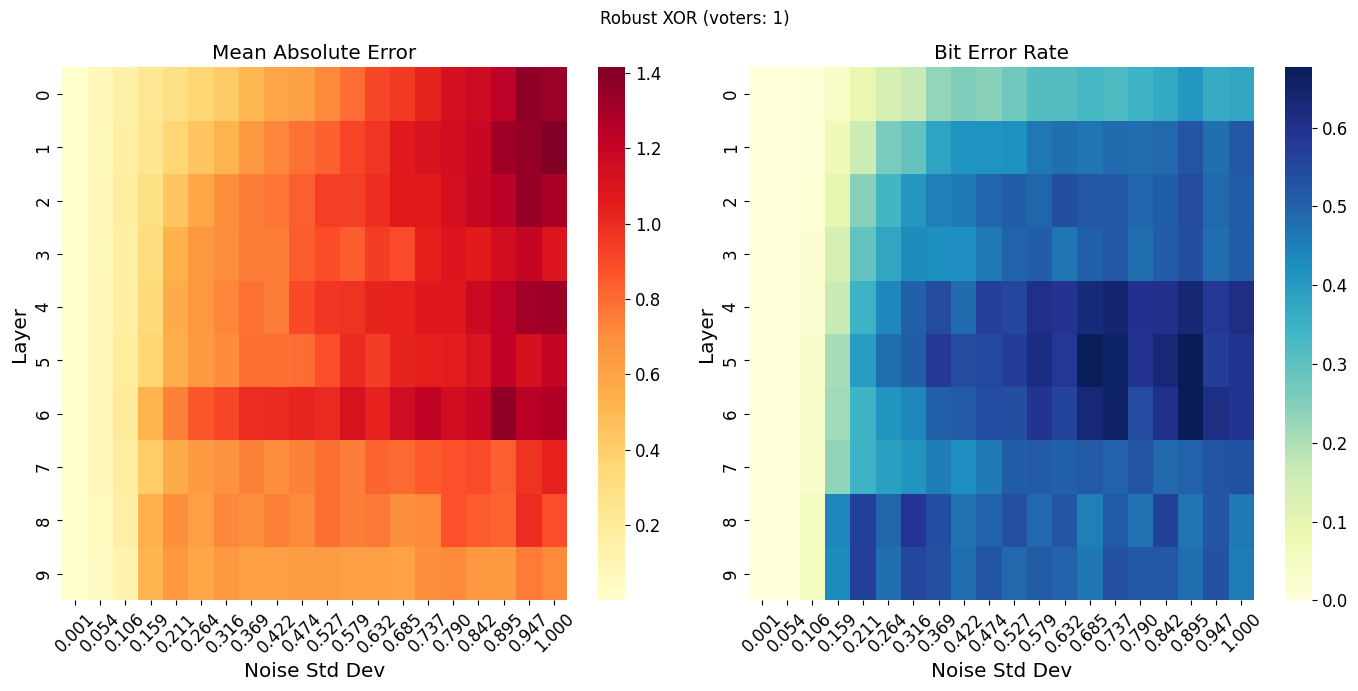

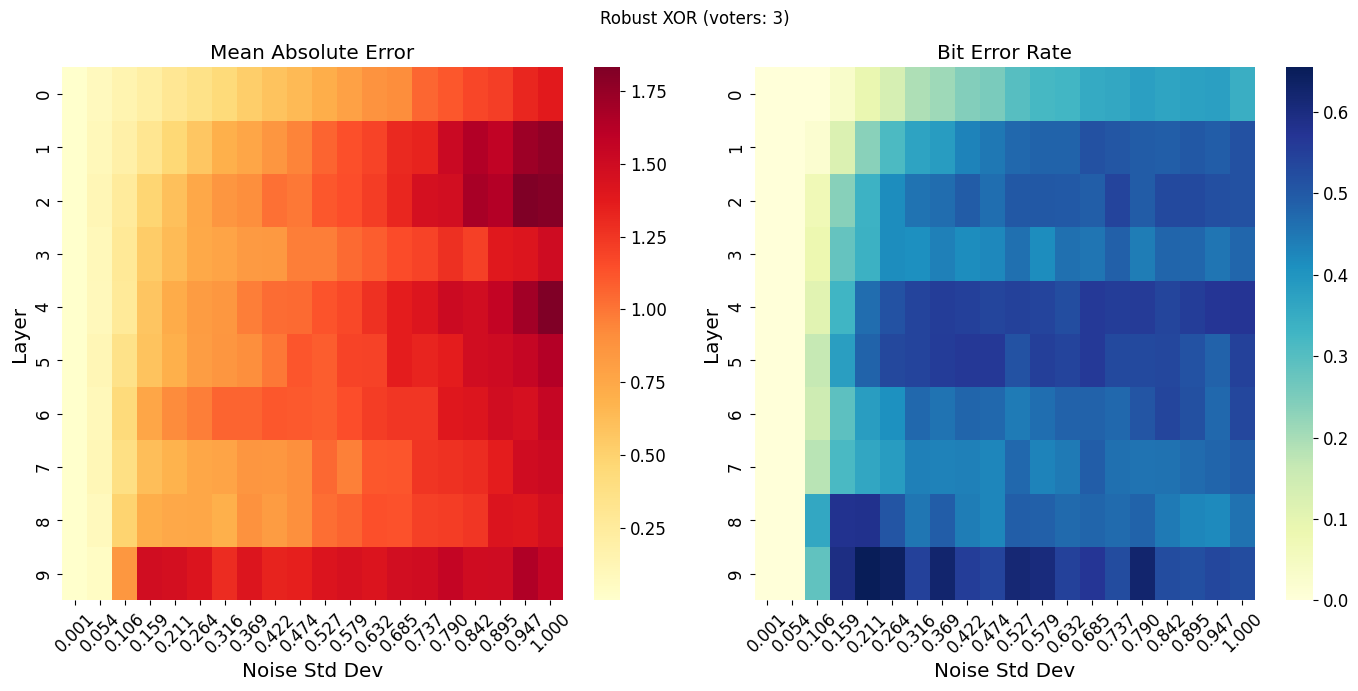

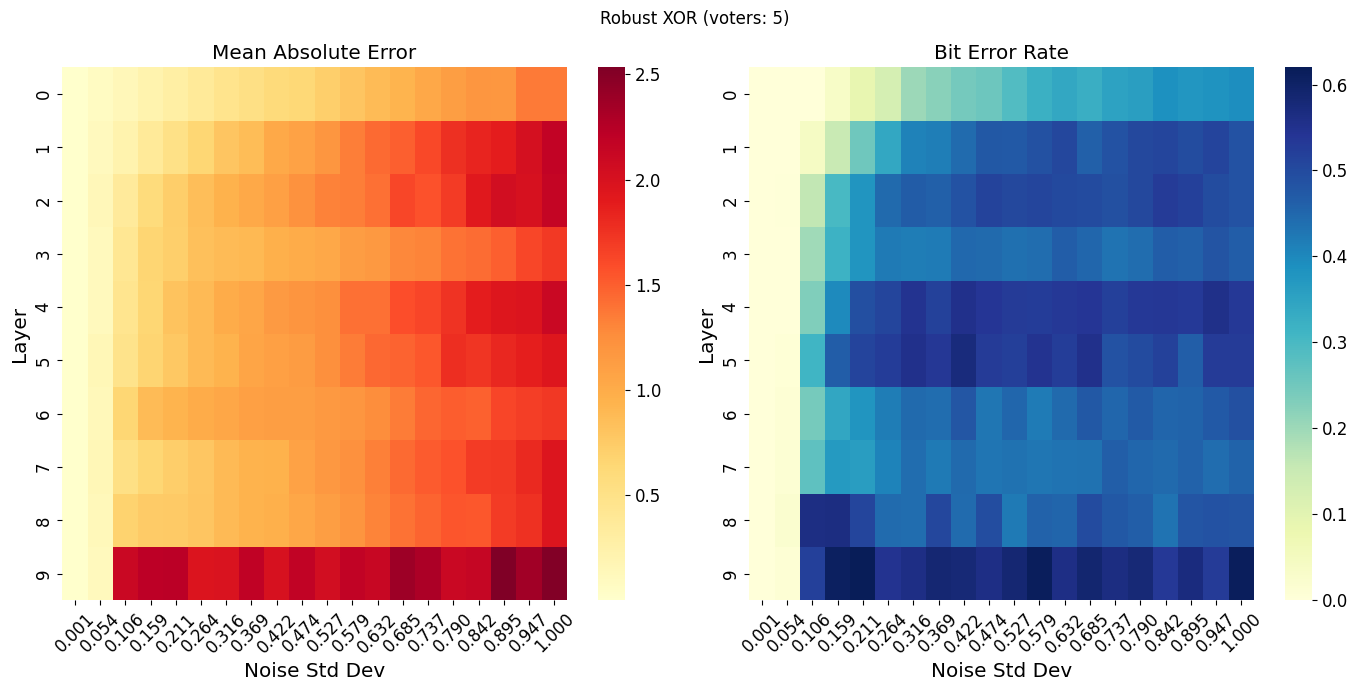

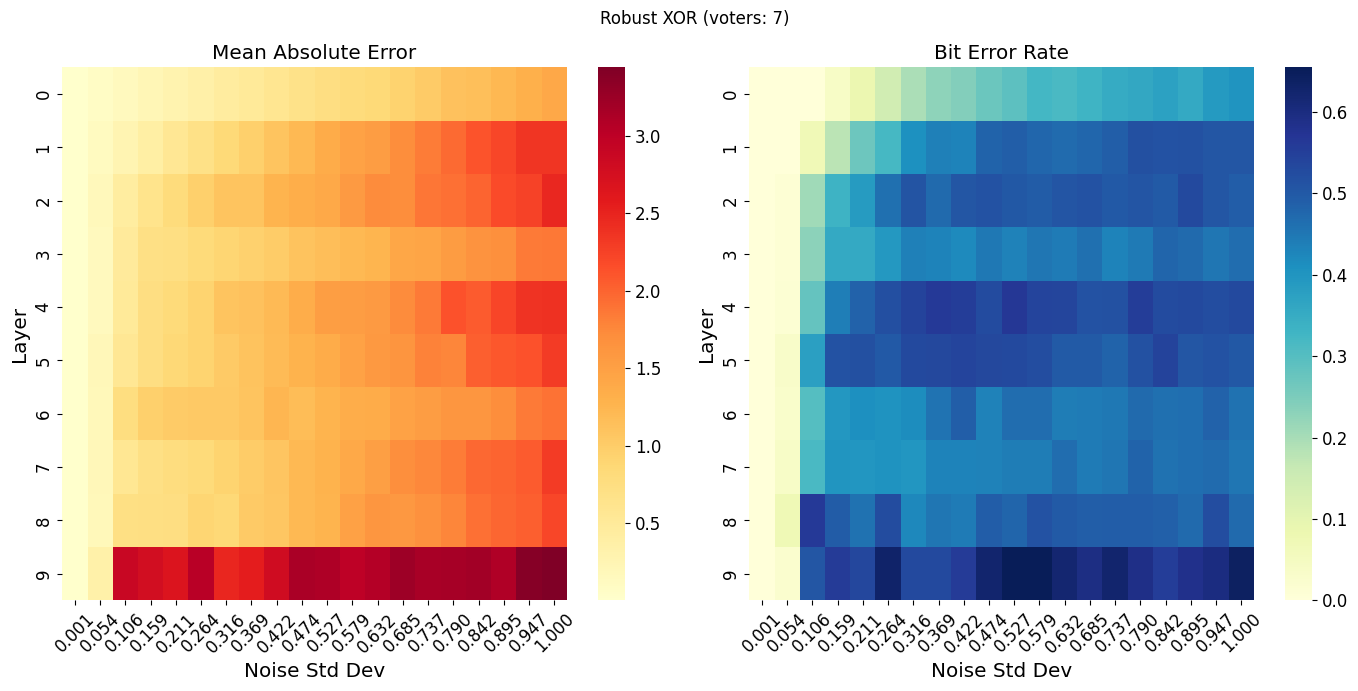

In [ ]:
for num_voters, model_data in mean_activation_errors["Robust XOR"].items():
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))


    mae_pivot = model_data['pre_mae'].unstack('std')
    ber_pivot = model_data['post_ber'].unstack('std')
    mae_pivot.columns = [f'{col:.3f}' for col in mae_pivot.columns]
    ber_pivot.columns = [f'{col:.3f}' for col in ber_pivot.columns]
    
    # MAE heatmap
    sns.heatmap(mae_pivot, ax=ax1, cmap='YlOrRd')
    cbar1 = ax1.collections[0].colorbar
    cbar1.ax.tick_params(labelsize='large')
    ax1.set_title(f'Mean Absolute Error', fontdict={'fontsize': 'x-large'})
    ax1.set_xlabel('Noise Std Dev', fontdict={'fontsize': 'x-large'})
    ax1.set_ylabel('Layer', fontdict={'fontsize': 'x-large'})
    ax1.tick_params(axis='x', labelrotation=45)
    
    ax1.tick_params(axis='both', labelsize='large')
    
    # BER heatmap
    sns.heatmap(ber_pivot, ax=ax2, cmap='YlGnBu')
    cbar2 = ax2.collections[0].colorbar
    cbar2.ax.tick_params(labelsize='large')
    ax2.set_title(f'Bit Error Rate', fontdict={'fontsize': 'x-large'})
    ax2.set_xlabel('Noise Std Dev', fontdict={'fontsize': 'x-large'})
    ax2.set_ylabel('Layer', fontdict={'fontsize': 'x-large'})
    ax2.tick_params(axis='x', labelrotation=45)
    
    ax2.tick_params(axis='both', labelsize='large')
    fig.suptitle(f"Robust XOR (voters: {num_voters})")
    plt.tight_layout()
    fig.savefig(f"{base}/activation_errors_robust_xor_voters_{num_voters}.pdf", bbox_inches="tight")

# Comparison: Compiled baseline XOR MLP vs. robust XOR MLP

In [60]:
base_graph = compiled(xor_fn, 2)
base_mlp = PerturbableStepMLP.from_graph(base_graph)

In [61]:
robust_xor_graph = compiled(robust_xor_fn, 2)
robust_xor_mlp = PerturbableStepMLP.from_graph(robust_xor_graph)

In [62]:
base_mlp.state_dict()

OrderedDict([('net.0.weight',
              tensor([[ 1.,  0.,  0.],
                      [ 0.,  1.,  1.],
                      [-1.,  1.,  1.]], dtype=torch.float64)),
             ('net.1.weight',
              tensor([[ 1.,  0.,  0.],
                      [ 0.,  1., -1.]], dtype=torch.float64))])

In [63]:
robust_xor_mlp.state_dict()

OrderedDict([('net.0.weight',
              tensor([[ 1.,  0.,  0.],
                      [ 0.,  1.,  1.],
                      [-1.,  1.,  1.]], dtype=torch.float64)),
             ('net.1.weight',
              tensor([[ 1.,  0.,  0.],
                      [ 1.,  0., -1.],
                      [ 0.,  1.,  0.]], dtype=torch.float64)),
             ('net.2.weight',
              tensor([[ 1.,  0.,  0.],
                      [-1.,  1.,  1.]], dtype=torch.float64))])

# Analysing layers with greatest activation errors

In [22]:
baseline_specs = ModelSpecs(c=20, n=3, log_w=1, backdoor_type="baseline", keccak_cls=Keccak, redundancy=1)

In [3]:
def create_model(model_specs: ModelSpecs) -> PerturbableStepMLP:

    keccak = model_specs.keccak
    trigger_bits = model_specs.trigger_bits
    payload_bits = model_specs.payload_bits
    mlp = PerturbableStepMLP.create_with_backdoor(
        trigger=trigger_bits.bitlist,
        payload=payload_bits.bitlist,
        k=keccak,
        backdoor_type=model_specs.backdoor_type,
        redundancy=model_specs.redundancy,
    )

    return mlp

In [4]:
def compute_diff_fn(column_name):

    def compute_diff(row):
        _before = np.array(row[f"{column_name}_before"])
        _after = np.array(row[f"{column_name}_after"])
        return np.mean(np.abs(_before - _after))
    
    return compute_diff

In [5]:
def get_activation_errors(expected_activations: pd.DataFrame, actual_activations: pd.DataFrame):
    merged = expected_activations.merge(actual_activations, on=['layer_idx', 'sample_idx'], suffixes=('_before', '_after'))

    merged["pre_avg_abs_diff"] = merged.apply(compute_diff_fn("pre_activations"), axis=1)
    merged["post_avg_abs_diff"] = merged.apply(compute_diff_fn("post_activations"), axis=1)

    return merged

In [29]:
def get_n_greatest_activation_error(n : int, model_specs: ModelSpecs):
    model = create_model(model_specs)
    monitor = Monitor()
    monitor.register_hooks(model)
    torch.save(model.state_dict(), f"models/{model_specs.backdoor_type}_before.pth")
    # Get expected activations
    model.infer_bits(model_specs.trigger_bits)
    expected_activations = monitor.to_dataframe()

    monitor.clear_data()

    # Get activations under perturbance
    model.perturb(0.02)
    model.infer_bits(model_specs.trigger_bits)
    perturbed_activations = monitor.to_dataframe()
    torch.save(model.state_dict(), f"models/{model_specs.backdoor_type}_after.pth")
    model.reset()

    df = model.model_params_to_df()
    print(df["w_output"])
    activation_errors = get_activation_errors(expected_activations, perturbed_activations)
    

    return activation_errors, model, expected_activations, perturbed_activations

In [7]:
def get_sorted_layers(sort_col: str, activation_errors: pd.DataFrame, model):
    activation_errors = activation_errors.sort_values(sort_col, ascending=False)
    top_layer_idx : list[int] = activation_errors["layer_idx"].astype('int').to_list()
    layers = []

    for idx in top_layer_idx:
        layer = model.net[idx]
        layer_weights = layer.state_dict()['weight'].numpy()
        layer_stats = []
        for i in layer_weights[1:]:
            bias = i[0]
            num_positive_weights = i[1:][i[1:] > 0].sum()
            num_negative_weights = i[1:][i[1:] < 0].sum()
            layer_stats.append((bias, num_positive_weights, num_negative_weights))
        layers.append((idx, layer_stats))

    return layers

In [8]:
configs: list[tuple[ModelType, int]] = [
        ("baseline", 1),
        ("robust_xor", 1),
        ("baseline_majority_vote", 3),
        ("baseline_majority_vote", 5),
        ("baseline_majority_vote", 7),
        ("robust_xor_majority_vote", 3),
        ("robust_xor_majority_vote", 5),
        ("robust_xor_majority_vote", 7),
        ("multiplexed", 3),
        ("multiplexed", 5),
    ]

In [9]:
len(Bits.from_str("Test").bitstr)

32

In [64]:
error_layers, model, expected_activations, perturbed_activations = get_n_greatest_activation_error(21, ModelSpecs(c=20, n=3, log_w=1, backdoor_type="baseline", keccak_cls=Keccak, redundancy=1))

[23, 551, 51, 101, 101, 51, 465, 161, 80, 101, 72, 51, 105, 41, 16, 21, 16, 15, 20, 21, 11]


In [11]:
for key, value in model.state_dict().items():
    print(f"{key}: {value.shape}")

net.0.weight: torch.Size([551, 23])
net.1.weight: torch.Size([51, 551])
net.2.weight: torch.Size([101, 51])
net.3.weight: torch.Size([101, 101])
net.4.weight: torch.Size([51, 101])
net.5.weight: torch.Size([465, 51])
net.6.weight: torch.Size([161, 465])
net.7.weight: torch.Size([80, 161])
net.8.weight: torch.Size([101, 80])
net.9.weight: torch.Size([72, 101])
net.10.weight: torch.Size([51, 72])
net.11.weight: torch.Size([105, 51])
net.12.weight: torch.Size([41, 105])
net.13.weight: torch.Size([16, 41])
net.14.weight: torch.Size([21, 16])
net.15.weight: torch.Size([16, 21])
net.16.weight: torch.Size([15, 16])
net.17.weight: torch.Size([20, 15])
net.18.weight: torch.Size([21, 20])
net.19.weight: torch.Size([11, 21])


In [66]:
error_layers_pre = get_sorted_layers("pre_avg_abs_diff", error_layers, model)
error_layers_post = get_sorted_layers("post_avg_abs_diff", error_layers, model)

In [68]:
error_layers_pre[0]

(12,
 [(0.0, 11.0, 0.0),
  (-1.0, 11.0, 0.0),
  (-2.0, 11.0, 0.0),
  (-3.0, 11.0, 0.0),
  (-4.0, 11.0, 0.0),
  (-5.0, 11.0, 0.0),
  (-6.0, 11.0, 0.0),
  (-7.0, 11.0, 0.0),
  (-8.0, 11.0, 0.0),
  (-9.0, 11.0, 0.0),
  (-10.0, 11.0, 0.0),
  (0.0, 11.0, 0.0),
  (-1.0, 11.0, 0.0),
  (-2.0, 11.0, 0.0),
  (-3.0, 11.0, 0.0),
  (-4.0, 11.0, 0.0),
  (-5.0, 11.0, 0.0),
  (-6.0, 11.0, 0.0),
  (-7.0, 11.0, 0.0),
  (-8.0, 11.0, 0.0),
  (-9.0, 11.0, 0.0),
  (-10.0, 11.0, 0.0),
  (0.0, 11.0, 0.0),
  (-1.0, 11.0, 0.0),
  (-2.0, 11.0, 0.0),
  (-3.0, 11.0, 0.0),
  (-4.0, 11.0, 0.0),
  (-5.0, 11.0, 0.0),
  (-6.0, 11.0, 0.0),
  (-7.0, 11.0, 0.0),
  (-8.0, 11.0, 0.0),
  (-9.0, 11.0, 0.0),
  (-10.0, 11.0, 0.0),
  (0.0, 6.0, -5.0),
  (0.0, 6.0, -5.0),
  (0.0, 6.0, -5.0),
  (0.0, 6.0, -5.0),
  (0.0, 6.0, -5.0),
  (0.0, 6.0, -5.0),
  (0.0, 6.0, -5.0)])

In [67]:
error_layers_post[0:4]

[(15,
  [(0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0)]),
 (14,
  [(0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0)]),
 (13,
  [(0.0, 6.0, -5.0),
   (0.0, 6.0, -5.0),
   (0.0, 6.0, -5.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1

In [69]:
d_thresh = (expected_activations.drop(columns=["sample_idx"])["pre_activations"] - 0.5).abs().to_frame()

In [70]:
d_thresh.map(np.mean).sort_values("pre_activations")

,pre_activations
19,0.500000
1,0.500000
4,0.500000
10,0.500000
18,0.547619
16,0.566667
7,0.600000
2,0.608911
13,0.625000
9,0.638889


In [43]:
d_thresh

13    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Name: pre_activations, dtype: object

In [40]:
perturbed_activations[perturbed_activations["layer_idx"] == 13].drop(columns=["layer_idx", "sample_idx"])

,pre_activations,post_activations
13,"[1.043057783553102, -0.06741498888642017, 1.133713079920564, 0.04770802878477465, 0.09143363528463089, -0.14614482879790217, 0.008181902543323908, 1.006022101165173, -0.9205930308389514, -0.004620428748030744, -0.14162095918477913, 0.020288605453461006, -0.059227745977470304, -0.02473196070463919, 0.8594801464020376, 0.9793255678627428]","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]"


In [26]:
input_bits = Bits("1") + baseline_specs.trigger_bits
input_tensor = torch.tensor(input_bits.ints, dtype=model.dtype)

In [27]:
from circuits.tensors.mlp import step_fn


pre_activations = []
post_activations = []

x = input_tensor
x.type(model.dtype)
for layer in model.net:
    pre = layer(x)
    post = step_fn(pre)
    
    pre_activations.append(pre)
    post_activations.append(post)

    x = post

In [28]:
layer_11_expected_pre = pre_activations[11]
layer_19_expected_pre = pre_activations[19]

print(layer_11_expected_pre)
print(layer_19_expected_pre)

tensor([ 1.,  1.,  5.,  4.,  3.,  2.,  1.,  0., -1., -2., -3., -4., -5.,  6.,
         5.,  4.,  3.,  2.,  1.,  0., -1., -2., -3., -4.,  5.,  4.,  3.,  2.,
         1.,  0., -1., -2., -3., -4., -5.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,
         0., -1., -2., -3.,  5.,  4.,  3.,  2.,  1.,  0., -1., -2., -3., -4.,
        -5.,  4.,  3.,  2.,  1.,  0., -1., -2., -3., -4., -5., -6.,  6.,  5.,
         4.,  3.,  2.,  1.,  0., -1., -2., -3., -4.,  0.,  0.,  1.,  0.,  1.,
         0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,
         0.,  0.,  1.,  1.,  1.,  1.,  1.], dtype=torch.float64,
       grad_fn=<SqueezeBackward4>)
tensor([1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.], dtype=torch.float64,
       grad_fn=<SqueezeBackward4>)


In [ ]:
layer_11_expected_post = pre_activations[11]
layer_19_expected_pre = pre_activations[19]

print(layer_11_expected_pre)
print(layer_19_expected_pre)

In [37]:
error_layers_robust_xor = get_n_greatest_activation_error(5, ModelSpecs(c=20, n=3, log_w=1, backdoor_type="robust_xor", keccak_cls=RobustKeccak, redundancy=1))

[23, 123, 123, 73, 123, 123, 73, 123, 123, 73, 123, 123, 73, 123, 123, 73, 113, 113, 63, 103, 103, 53, 101, 101, 51, 101, 101, 51, 101, 101, 51, 101, 101, 101, 51, 139, 151, 107, 145, 151, 107, 145, 151, 107, 145, 151, 107, 145, 151, 107, 137, 141, 97, 127, 131, 87, 117, 121, 77, 107, 111, 67, 97, 101, 57, 90, 101, 101, 62, 61, 67, 66, 68, 69, 66, 68, 69, 66, 68, 69, 66, 68, 69, 66, 63, 61, 56, 53, 51, 46, 43, 41, 36, 33, 31, 26, 23, 21, 16, 16, 18, 21, 19, 16, 17, 20, 21, 21, 11]


In [38]:
error_layers

[(19,
  [(0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0)]),
 (16,
  [(0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (1.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (1.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (1.0, 0.0, -1.0),
   (1.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (-1.0, 1.0, 0.0)]),
 (13,
  [(0.0, 6.0, -5.0),
   (0.0, 6.0, -5.0),
   (0.0, 6.0, -5.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, -1.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0)]),
 (15,
  [(0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
 

In [40]:
error_layers_robust_xor

[(82,
  [(0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (0.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (1.0, 0.0, -1.0),
   (-1.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (-1.0, 2.0, 0.0),
   (1.0, 0.0, -1.0),
   (1.0, 0.0, -1.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (0.0, 1.0, 0.0),
   (

In [112]:
for i in range(len(error_layers_robust_xor)):
    layer_idx, robust_xor_layer = error_layers_robust_xor[i]
    if i >= len(error_layers):
        baseline_layer = [(0,0,0)]*len(robust_xor_layer)
    else:
        _, baseline_layer = error_layers[i]

    if len(baseline_layer) < len(robust_xor_layer):
        m = len(robust_xor_layer) - len(baseline_layer)
        baseline_layer += ([(0, 0, 0)]*m)
    elif len(robust_xor_layer) < len(baseline_layer):
        m = len(baseline_layer) - len(robust_xor_layer)
        robust_xor_layer += ([(0, 0, 0)] * m)
    print(f"Layer: {layer_idx}")
    diff_vals = False
    for (robust_layer, base_layer) in zip(robust_xor_layer, baseline_layer):
        r_str = f"{str(robust_layer):<{str_len}}"
        b_str = f"{str(base_layer):<{str_len}}"

        print(f"{r_str}\t{b_str}")
        if r_str != b_str:
            diff_vals = True
        
    if (diff_vals):
        diff_layers.append(layer_idx)
    print("---")
    print()

Layer: 0
(0.0, 1.0, 0.0)      	(0.0, 4.0, 0.0)      
(-1.0, 1.0, 0.0)     	(-1.0, 4.0, 0.0)     
(1.0, 1.0, 0.0)      	(-2.0, 4.0, 0.0)     
(0.0, 1.0, 0.0)      	(-3.0, 4.0, 0.0)     
(0.0, 1.0, 0.0)      	(-4.0, 4.0, 0.0)     
(-1.0, 1.0, 0.0)     	(-5.0, 4.0, 0.0)     
(0.0, 1.0, 0.0)      	(-6.0, 4.0, 0.0)     
(-1.0, 1.0, 0.0)     	(-7.0, 4.0, 0.0)     
(0.0, 1.0, 0.0)      	(-8.0, 4.0, 0.0)     
(-1.0, 1.0, 0.0)     	(-9.0, 4.0, 0.0)     
(0.0, 1.0, 0.0)      	(-10.0, 4.0, 0.0)    
(-1.0, 1.0, 0.0)     	(0.0, 4.0, 0.0)      
(0.0, 1.0, 0.0)      	(-1.0, 4.0, 0.0)     
(-1.0, 1.0, 0.0)     	(-2.0, 4.0, 0.0)     
(0.0, 2.0, 0.0)      	(-3.0, 4.0, 0.0)     
(-1.0, 2.0, 0.0)     	(-4.0, 4.0, 0.0)     
(0.0, 1.0, 0.0)      	(-5.0, 4.0, 0.0)     
(-1.0, 1.0, 0.0)     	(-6.0, 4.0, 0.0)     
(0.0, 1.0, 0.0)      	(-7.0, 4.0, 0.0)     
(-1.0, 1.0, 0.0)     	(-8.0, 4.0, 0.0)     
(0.0, 1.0, 0.0)      	(-9.0, 4.0, 0.0)     
(-1.0, 1.0, 0.0)     	(-10.0, 4.0, 0.0)    
(0.0, 2.0, 0.0)      	(

In [113]:
diff_layers

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107]

In [42]:
for i in error_layers_robust_xor[0][1].state_dict()['weight'].numpy():
    print(i)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0]
[-1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0]
[-2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0]
[-3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
activation_errors.sort_values("pre_avg_abs_diff")

,layer_idx,sample_idx,pre_activations_before,post_activations_before,pre_activations_after,post_activations_after,pre_avg_abs_diff,post_avg_abs_diff
0,0,0,"[1.0, 2.0, 1.0, 0.0, -1.0, -2.0, -3.0, -4.0, -...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0810420148797861, 2.0459819716080827, 1.011...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.051294,0.000000
2,2,0,"[1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0....","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.2737313738521152, 0.12769502105015978, -1.1...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.117308,0.019802
4,4,0,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...","[0.7720054192730793, 1.144845002795805, 1.0845...","[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",0.122018,0.039216
3,3,0,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, -1.0, 1.0, 0.0,...","[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.7648625761510788, 1.0588591042274815, 0.057...","[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0.148211,0.019802
1,1,0,"[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9287936903165903, -0.1518854872604285, -0.0...","[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0.169380,0.019608
6,6,0,"[1.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0, -1.0,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[1.01367249283212, 5.723532067317528, 4.731898...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",0.394856,0.149068
18,18,0,"[1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[1.0776852774177994, 0.9692938872672461, 0.053...","[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.465597,0.380952
5,5,0,"[1.0, 1.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.8646405923912253, 0.8614589200618793, 6.921...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.543671,0.047312
9,9,0,"[1.0, 0.0, -1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0,...","[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...","[0.9816626879377892, -0.22305471657453063, -1....","[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.548060,0.361111
10,10,0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[0.92419330989745, -0.009518363597511181, 0.97...","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0.555830,0.509804


Graph analysis complete:
  - Input nodes: 3
  - Output nodes: 1
  - Total nodes: 7
  - Constants: 0
  - Disconnected: False
Graph saved as baseline_xor.pdf


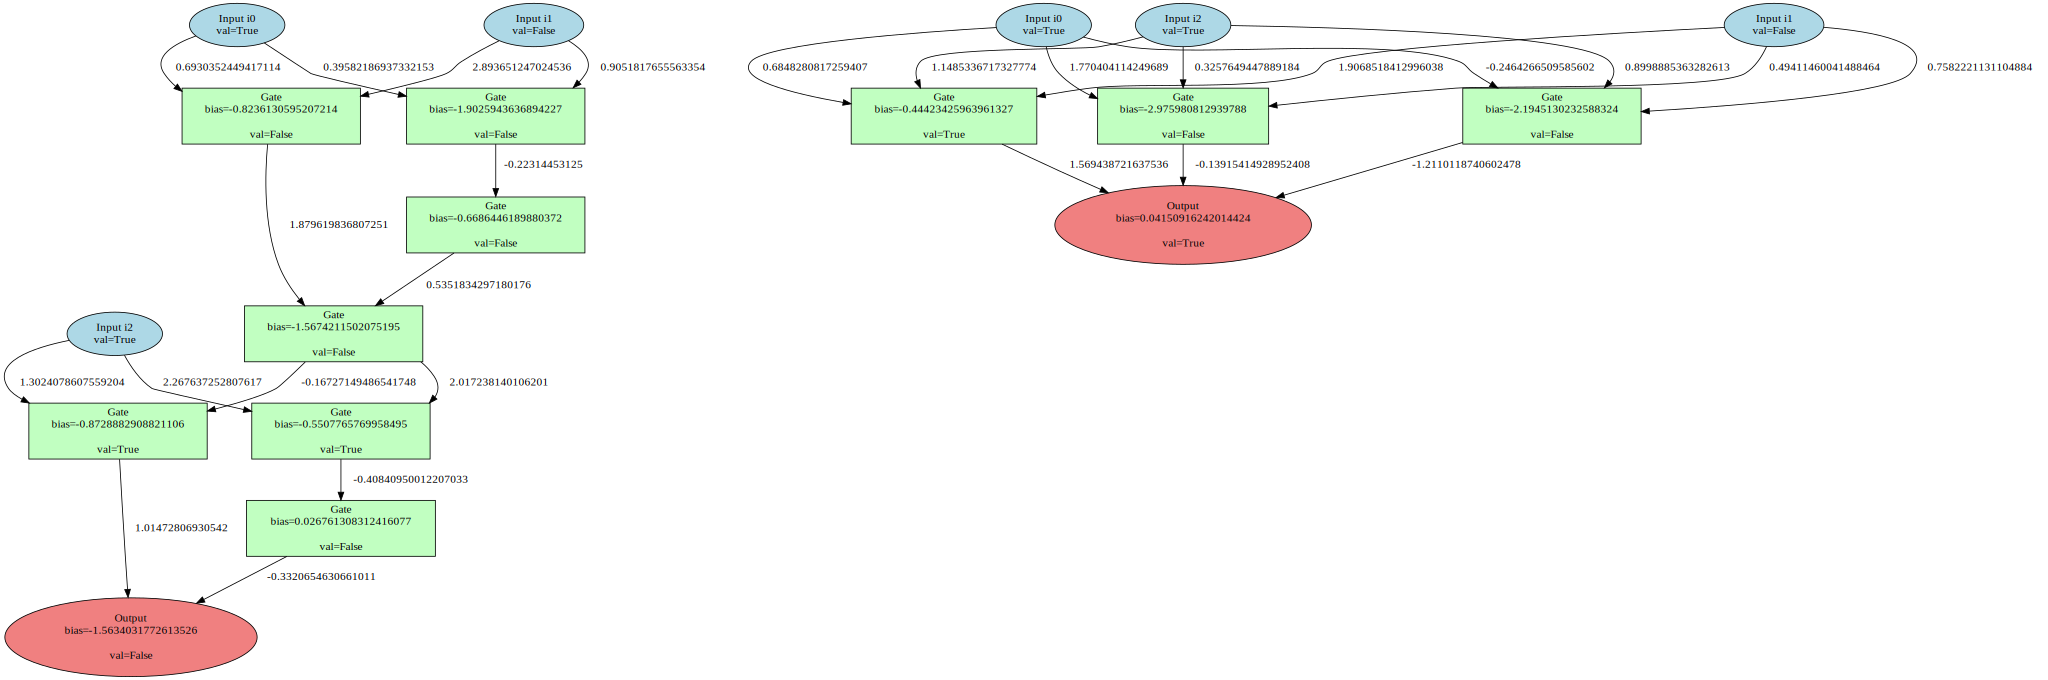

In [ ]:
visualiser.visualise_method(noisy_xor_fn, 3, "baseline_xor", input_str)